In [58]:
from __future__ import print_function

%matplotlib inline
from pyuvdata import UVData
from pyuvdata import UVCal
import os
import subprocess
import os.path
from os import path
import numpy as np
import matplotlib as mpl
#mpl.use('Agg')
from matplotlib import pyplot as plt
from astropy.coordinates import EarthLocation, SkyCoord, AltAz, Angle
from astropy.time import Time
import matplotlib.animation as anm
from scipy.interpolate import interp1d

In [59]:
#### Default Input Parameters ####

#Path to FHD run:
#path1 = "/lustre/aoc/projects/hera/dstorer/H3C_data/2458787/FHD_Output/streakOff"
path1 = "/lustre/aoc/projects/hera/dstorer/Projects/ssinsFHDRun/beamTesting/newParams"
ssinsPath = '/lustre/aoc/projects/hera/dstorer/H3C_data/2458791/ssinsFlagged/newShapeDict'
#JDs to execute on (assumes FHD results are organized into sub-directories by these names within path1)
days = ['2458098']
ant_nums = [51,70,52,53] #Antenna numbers to read in
#ant_nums = [11,12]
baselines = [(51,51),(70,70),(52,52),(53,53)]
plotName = 'H3C_SSINSFlagged_StreakOn' #Base name for plots
#outpath = "/lustre/aoc/projects/hera/dstorer/H3C_data/2458787/FHD_Output/streakOn/plots/" #Output directory for plots
frame_baseName = 'calMovieFrames' #Base name for movie frames
pol = 'Jxx' #Polarization to read in
freqrange=[120,185] #Frequency range (MHz) to read in and plot
visrange=[1,-1] #Range (indices) of observations array to read in and plot
colormap = 'plasma_r'
#Source to read calibration from (Either 'sav' for FHD .sav files, or 'fits' for UVCal cal.fits files:
#Note that for cal.fits files I assume they are stored in the calibration subdirectory with the same naming convention
source = 'sav'
#Option to write out a calfits file:
write_calfits = False



In [62]:
#### Setup paths and arrays ####

thedir = path1
vis = [name for name in os.listdir(thedir) if os.path.isdir(os.path.join(thedir, name))]
vis.sort()
vis = vis[1:-1]
obspath = path1 + '/' + vis[4]
data_array = {}

In [63]:
#Get telescope location:
dat = UVData()
version = vis[4]
print(version)
obsid = version.split('_')[1]
#print(obsid)
prefix = obspath + '/' + 'metadata' + '/' + obsid + '_'
files1 = [prefix + f for f in ['params.sav','settings.txt', 'layout.sav']]
prefix = obspath + '/' + 'vis_data' + '/' + obsid + '_'
#print(prefix)
files2 = [prefix + f for f in ['flags.sav','vis_XX.sav','vis_YY.sav','vis_model_XX.sav','vis_model_YY.sav']]
files = np.append(files1, files2)
#print(files)

dat.read_fhd(files)
loc = EarthLocation.from_geocentric(*dat.telescope_location, unit='m')

fhd_2458098.1280670976_1_20_newParams_flaggedAnts_ssinsFlagged20Sig


antenna_diameters is not set. Using known values for HERA.


In [64]:
def get_zenithRA(time_array,telescope_location):
    zens = []
    for t in time_array:
        if t is None:
            zens.append(zens[-1] + (zens[-1]-zens[-2]))
        else:
            zen = SkyCoord(Angle(0, unit='deg'),Angle(90,unit='deg'),frame='altaz',obstime=t,location=telescope_location)
            zen = zen.transform_to('icrs')
            zen = zen.ra.degree
            zens.append(zen)
    return zens

In [65]:
def get_LSTs(time_array):
    lst_arr = []
    for i in range(len(time_array)):
        t = time_array[i]
        if t is not None:
            lst = t.sidereal_time('mean').hour
            lst_arr.append(lst)
        else:
            if i == 0:
                lst = 0
            else:
                lst = lst_arr[-1]+0.0139
            lst_arr.append(lst)
    return lst_arr

In [66]:
def readFHDVisibilities(baselines=baselines, days=days, path1=path1, polarization='XX', use_model=False):
    vis_array = {}
    for k in range(len(days)):
        vis = [ name for name in os.listdir(path1) if os.path.isdir(os.path.join(path1, name)) and 'fhd_' in name ]
        vis.sort()
        vis = vis[visrange[0]:visrange[1]]
        obs1 = vis[3].split('_')[1]
        path = '%s/%s' % (path1,vis[3])
        uv = UVData()
        fhd_files = []
        fhd_files.append(path + '/metadata/' + obs1 + '_params.sav')
        fhd_files.append(path + '/metadata/' + obs1 + '_settings.txt')
        fhd_files.append(path + '/metadata/' + obs1 + '_layout.sav')
        vis_files = ['flags.sav','vis_XX.sav','vis_YY.sav','vis_model_XX.sav','vis_model_YY.sav']
        for f in vis_files:
            fhd_files.append(path + '/vis_data/' + obs1 + '_' + f)
        uv.read_fhd(fhd_files, use_model=use_model)
        nfreqs = len(uv.freq_array[0])
        ntimes = len(np.unique(uv.time_array))
        freq_array = uv.freq_array[0]*10**(-6)
        day_array = {}
        for b in baselines:
            day_array[b] = np.zeros((len(vis)*ntimes,nfreqs))
        for i in range(len(vis)):
            v = vis[i]
            obs = v.split('_')[1]
            print(obs)
            path = '%s/%s' % (path1,v)
            if os.path.exists(path + '/vis_data/') is False:
                if i == 0:
                    continue
                mask_array[i*ntimes:(i+1)*ntimes,:] = np.ones(np.shape(vis_data))
                for b in baselines:
                    day_array[b][i*ntimes:(i+1)*ntimes,:] = vis_data
            else:
                uv = UVData()
                fhd_files = []
                fhd_files.append(path + '/metadata/' + obs + '_params.sav')
                fhd_files.append(path + '/metadata/' + obs + '_settings.txt')
                fhd_files.append(path + '/metadata/' + obs + '_layout.sav')
                vis_files = ['flags.sav','vis_XX.sav','vis_YY.sav','vis_model_XX.sav','vis_model_YY.sav']
                for f in vis_files:
                    fhd_files.append(path + '/vis_data/' + obs + '_' + f)
                uv.read_fhd(fhd_files, use_model=use_model)
                ntimes = len(np.unique(uv.time_array))
                if i == 0:
                    mask_array = np.zeros((ntimes*len(vis),nfreqs))
                for b in baselines:
                    vis_data = np.abs(uv.get_data(b[0], b[1], polarization))
                    day_array[b][i*ntimes:(i+1)*ntimes,:] = vis_data
        for b in baselines:
            day_array[b] = np.ma.masked_array(day_array[b],mask=mask_array)
        vis_array[days[k]] = day_array
    return vis_array

In [67]:
def readRawVisibilities(baselines=baselines, days=days, path1=ssinsPath, polarization='XX', jdrange=None, ant_nums='all'):
    vis_array = {}
    for k in range(len(days)):
        day_array = {}
        for b in baselines:
            day_array[b] = []
        vis = [ name for name in os.listdir(path1) if name.endswith(".HH.uvh5") ]
        vis.sort()
        if jdrange != None:
            jds = [float(name.split('.')[2]) for name in vis]
            minind = np.argmin(np.abs(np.subtract(jds,jdrange[0])))
            maxind = np.argmin(np.abs(np.subtract(jds,jdrange[1])))
            vis = vis[minind:maxind]
        for i in range(len(vis)):
            v = vis[i]
            print(v)
            path = '%s/%s' % (path1,v)
            uv = UVData()
            if ant_nums == 'all':
                uv.read(path)
            else:
                uv.read(path, antenna_nums = ant_nums)
            for b in baselines:
                vis_data = uv.get_data(b[0], b[1], polarization)
                for x in vis_data[:]:
                    day_array[b].append(x)
        vis_array[days[k]] = day_array
    return vis_array

In [ ]:
vis_array = readRawVisibilities(path1='/lustre/aoc/projects/hera/H1C_IDR2/IDR2_2/2458098', 
                                jdrange=[50000,70000], ant_nums=ant_nums)

Text(0.5, 1.0, 'raw visibilities')

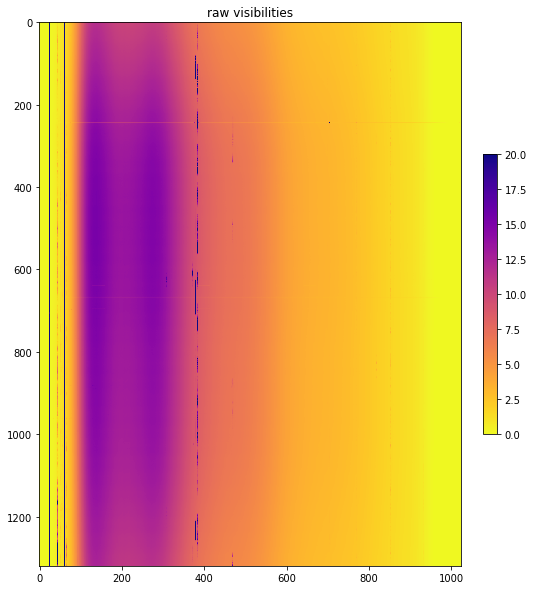

In [140]:
fig = plt.figure(figsize=(10,10))
dat51 = vis_array[days[0]][(51,51)]
print(dat)
datReal = np.abs(np.real(dat51))
datAmp = np.abs(dat51)
im = plt.imshow(datAmp, cmap=colormap, vmin=0,vmax=20)
plt.colorbar(im,fraction=0.025, pad=0.04)
plt.title('raw visibilities')

In [68]:
def readCalSolutions(ant_nums=ant_nums, days=days, path1=path1, source=source):
    data_array = {}
    cal = UVCal()
    nants = len(ant_nums)
    for k in range(len(days)):
        day_array = {}
        thedir = path1
        vis = [ name for name in os.listdir(thedir) if os.path.isdir(os.path.join(thedir, name)) and 'fhd_' in name ]
        vis.sort()
        vis = vis[visrange[0]:visrange[1]]
        for j in range(nants):
            nocal = 0
            i=0
            times = []
            for v in vis:
                data = True
                obs = v.split('_')[1]
                print('Reading data for antenna ' + str(ant_nums[j]) + ', Obs ' + str(obs))
                path = path1 + '/' + v
                if os.path.exists(path + '/calibration/') is False:
                    print('!!!!!!!!!!!!!!!!!!!!WARNING!!!!!!!!!!!!!!!!!!!')
                    print('There is no calibration data for this observation. The gains for this observation will masked.')
                    nocal = nocal + 1
                    data = False
                    times.append(None)
                if source == 'sav':
                    if data == True:
                        obsfile = path + '/metadata/' + obs + '_obs.sav'
                        calfile = path + '/calibration/' + obs + '_cal.sav'
                        settingsfile = path + '/metadata/' + obs + '_settings.txt'
                        cal.read_fhd_cal(calfile,obsfile,settings_file=settingsfile)
                elif source == 'fits':
                    calfits = path + str(nums[i]) + '/calibration/' + obs + '_cal.fits'
                    cal.read_calfits(calfits)
                else:
                    print('####################### ERROR #####################')
                    print('The source must be set to either sav or fits')
                if write_calfits == True and data == True:
                    outpath = path + str(nums[i]) + '/calibration/' + obs + '_cal.fits'
                    cal.write_calfits(outpath, clobber=True)
                if i == 0 and data==True:
                    nobs = len(vis)
                    nfreqs = cal.Nfreqs
                    freq_array = cal.freq_array[0,:]
                    freq_array = np.transpose(freq_array)
                    freq_array = np.divide(freq_array,1000000)
                    minfreqind = np.argmax(freq_array>freqrange[0])
                    maxfreqind = np.argmin(freq_array<freqrange[1])
                    cal_array = np.empty((nfreqs,nobs))
                    mask_array = np.zeros((nfreqs,nobs))
                    if j == 0:
                        ## Get the LST start and end times for this obsid ##
                        time_array = cal.time_array
                        obstime_start = Time(time_array[0],format='jd',location=loc)
                        startTime = obstime_start.sidereal_time('mean').hour
                        JD = int(obstime_start.jd)
                if v == vis[-1] and j == 0:
                    time_array = cal.time_array
                    obstime_end = Time(time_array[-1],format='jd',location=loc)
                    endTime = obstime_end.sidereal_time('mean').hour
                if data is True:
                    gain = np.abs(cal.get_gains(ant_nums[j], pol))
                if data is False:
                    if i == 0:
                        continue
                    else:
                        gain = np.zeros(np.shape(gain))
                        cal_array[:,i] = gain[:,0]
                        mask_array[:,i] = np.ones(np.shape(gain))[:,0]
                        i = i + 1
                        continue
                cal_array[:,i] = gain[:,0]
                i = i + 1
                tArr = cal.time_array
                t = Time(tArr[0],format='jd',location=loc)
                times.append(t)
            cal_array = np.transpose(cal_array)
            mask_array = np.transpose(mask_array)
            cal_array = cal_array[:,minfreqind:maxfreqind]
            mask_array = mask_array[:,minfreqind:maxfreqind]
            ## Getting max and min values ##
            calsort = np.sort(cal_array)
            maxind = int(len(calsort[0])/15)
            maxuse = calsort[:,-maxind]
            maxuse = np.max(maxuse)
            if maxuse >=5:
                    maxind = int(len(calsort[0])/12)
                    maxuse = calsort[:,-maxind]
                    maxuse = np.max(maxuse)
                    print('!!!!!!!!!!!!!!!!!!! Had to adjust max used value !!!!!!!!!!!!!!!!!!!')
            maxval = np.max(calsort[:,-1])
            print('Maximum gain value is: ' + str(maxval))
            print('Maximum gain value used is: ' + str(maxuse))
            freq_array = freq_array[minfreqind:maxfreqind]
            mx = np.ma.masked_array(cal_array, mask=mask_array)
            lst_array = get_LSTs(times)
            zenith_RAs = get_zenithRA(times,loc)
            res = {
                    "ant_num": ant_nums[j],
                    "obsid": obs,
                    "cal_array": cal_array,
                    "time_array": times,
                    "freq_array": freq_array,
                    "masked_data": mx,
                    "zenith_RA_array": zenith_RAs,
                    "lst_array": lst_array,
                    "pol": pol
                }
            antenna = ant_nums[j]
            day_array[antenna] = res
            print('###############################################################')
            print('Out of ' + str(len(vis)) + ' observations, ' + str(nocal) + ' did not contain calibration solutions')
            print('###############################################################')
        data_array[days[k]] = day_array
    return data_array

In [69]:
def getClippedFrequency(freq_array,mx,freq_range=[120,180]):
    idx0 = (np.abs(freq_array - freq_range[0])).argmin()
    idx1 = (np.abs(freq_array - freq_range[1])).argmin()
    freq_array = freq_array[idx0:idx1]
    mx = mx[:,idx0:idx1]
    return mx, freq_array

In [70]:
def getClippedTime(time_array,mx,lst_range=[2,8]):
    idx0 = (np.abs(time_array - np.asarray(lst_range[0]))).argmin()
    idx1 = (np.abs(time_array - np.asarray(lst_range[1]))).argmin()
    time_array = time_array[idx0:idx1]
    mx = mx[idx0:idx1,:]
    return mx, time_array, idx0, idx1

In [71]:
def plotWaterfalls(data_array,saveFig=False,plotName='',firstFileLines=False,freq_range=[120,180],lst_range='all',days=days,vmin=0,vmax=1,ant_nums=ant_nums):
    nants = len(ant_nums)
    for k in range(len(days)):
        fig, axs = plt.subplots(1, nants, figsize=(15,6))
        fig.subplots_adjust(hspace=0.5,wspace=0.5)
        fig.subplots_adjust(right=0.8)
        for j in range(nants):
            ant = ant_nums[j]
            mx = data_array[days[k]][ant]["masked_data"]
            freq_array = data_array[days[k]][ant]["freq_array"]
            if not freq_range == 'all':
                mx, freq_array = getClippedFrequency(freq_array,mx,freq_range)
            else:
                freq_range = np.around([freq_array[0],freq_array[-1]],0)
                print(freq_range)
            time_array = data_array[days[k]][ant]["lst_array"]
            zens = data_array[days[k]][ant]["zenith_RA_array"]
            if not lst_range == 'all':
                mx, time_array, idx0, idx1 = getClippedTime(time_array,mx,lst_range)
                zens = zens[idx0:idx1]
            currmap = mpl.cm.get_cmap()
            currmap.set_bad('black',1.)
            im = axs[j].imshow(
                mx, origin='upper', interpolation='none',
                cmap = colormap,
                aspect='auto', vmin=vmin, vmax=vmax
            )
            JD = days[k]
            axs[j].set_title('Antenna #' + str(ant) + ', JD: ' + str(JD))
            axs[j].set_xlabel('Frequency (MHz)')
            df = (freq_range[-1] - freq_range[0])/6
            freq_ticks = np.around([freq_range[0],freq_range[0],freq_range[0]+df,freq_range[0]+2*df,freq_range[-1]-2*df,freq_range[-1]-df,freq_range[-1]],0)
            axs[j].set_xticklabels(freq_ticks)
            if j == 0:
                axs[j].set_ylabel('Time (LST)')
                idx = np.round(np.linspace(0,len(time_array)-1,10)).astype(int)
                time_ticks = np.around([time_array[i] for i in idx],1)
                axs[j].set_yticklabels(time_ticks)
            elif j == (nants-1):
                axs[j].set_ylabel('RA of zenith (deg)',rotation=270,labelpad=20)
                idx = np.round(np.linspace(0,len(zens)-1,10)).astype(int)
                zen_ticks = np.around([zens[i] for i in idx],1)
                axs[j].set_yticklabels(zen_ticks)
                axs[j].yaxis.tick_right()
                axs[j].yaxis.set_label_position("right")
            else:
                axs[j].get_yaxis().set_ticklabels([])
            if firstFileLines == True:
                i = np.mod(visrange[0],12)
                while i < len(time_array):
                    axs[j].axhline(i,color='lightsteelblue')
                    i = i + 12
        cbar_ax = fig.add_axes([0.87,0.1,0.02,0.8])
        cbar = fig.colorbar(im, cax=cbar_ax)
        cbar.set_label('Gain Amplitude', rotation=270, labelpad=20)
        if saveFig == True:
            fig.savefig(outpath + str(days[k]) + '_waterfall_' + plotName)
            print('Saving figure to: ' + outpath + str(days[k]) + '_waterfall_' + plotName)

In [72]:
pyCalArray = readCalSolutions(ant_nums=[51])

Reading data for antenna 51, Obs 2458098.1262029624
Reading data for antenna 51, Obs 2458098.126824341
Reading data for antenna 51, Obs 2458098.127445719
Reading data for antenna 51, Obs 2458098.1280670976
Reading data for antenna 51, Obs 2458098.128688476
Reading data for antenna 51, Obs 2458098.1293098545
Reading data for antenna 51, Obs 2458098.129931233
Reading data for antenna 51, Obs 2458098.130552611
!!!!!!!!!!!!!!!!!!!!WARNING!!!!!!!!!!!!!!!!!!!
There is no calibration data for this observation. The gains for this observation will be entered as 0.
Reading data for antenna 51, Obs 2458098.1311739893
!!!!!!!!!!!!!!!!!!!!WARNING!!!!!!!!!!!!!!!!!!!
There is no calibration data for this observation. The gains for this observation will be entered as 0.
Reading data for antenna 51, Obs 2458098.1317953677
!!!!!!!!!!!!!!!!!!!!WARNING!!!!!!!!!!!!!!!!!!!
There is no calibration data for this observation. The gains for this observation will be entered as 0.
Reading data for antenna 51, Obs

Reading data for antenna 51, Obs 2458098.190826313
!!!!!!!!!!!!!!!!!!!!WARNING!!!!!!!!!!!!!!!!!!!
There is no calibration data for this observation. The gains for this observation will be entered as 0.
Reading data for antenna 51, Obs 2458098.1914476915
!!!!!!!!!!!!!!!!!!!!WARNING!!!!!!!!!!!!!!!!!!!
There is no calibration data for this observation. The gains for this observation will be entered as 0.
Reading data for antenna 51, Obs 2458098.19206907
!!!!!!!!!!!!!!!!!!!!WARNING!!!!!!!!!!!!!!!!!!!
There is no calibration data for this observation. The gains for this observation will be entered as 0.
Reading data for antenna 51, Obs 2458098.192690448
Reading data for antenna 51, Obs 2458098.1933118263
Reading data for antenna 51, Obs 2458098.1939332047
Reading data for antenna 51, Obs 2458098.194554583
Reading data for antenna 51, Obs 2458098.1951759616
Reading data for antenna 51, Obs 2458098.19579734
Reading data for antenna 51, Obs 2458098.1964187184
Reading data for antenna 51, Obs 2

Reading data for antenna 51, Obs 2458098.2554496634
Reading data for antenna 51, Obs 2458098.256071042
Reading data for antenna 51, Obs 2458098.25669242
Reading data for antenna 51, Obs 2458098.2573137986
Reading data for antenna 51, Obs 2458098.257935177
Reading data for antenna 51, Obs 2458098.2585565555
Reading data for antenna 51, Obs 2458098.259177934
Reading data for antenna 51, Obs 2458098.259799312
Reading data for antenna 51, Obs 2458098.2604206903
Reading data for antenna 51, Obs 2458098.2610420687
Reading data for antenna 51, Obs 2458098.261663447
Reading data for antenna 51, Obs 2458098.2622848256
Reading data for antenna 51, Obs 2458098.262906204
Reading data for antenna 51, Obs 2458098.2635275824
Reading data for antenna 51, Obs 2458098.264148961
Reading data for antenna 51, Obs 2458098.2647703392
Reading data for antenna 51, Obs 2458098.265391717
Reading data for antenna 51, Obs 2458098.2660130956
Reading data for antenna 51, Obs 2458098.266634474
Reading data for antenn

Reading data for antenna 51, Obs 2458098.334986095
Reading data for antenna 51, Obs 2458098.3356074733
Reading data for antenna 51, Obs 2458098.3362288517
Reading data for antenna 51, Obs 2458098.33685023
Reading data for antenna 51, Obs 2458098.3374716085
Reading data for antenna 51, Obs 2458098.338092987
Reading data for antenna 51, Obs 2458098.338714365
Reading data for antenna 51, Obs 2458098.3393357433
Reading data for antenna 51, Obs 2458098.3399571218
!!!!!!!!!!!!!!!!!!!!WARNING!!!!!!!!!!!!!!!!!!!
There is no calibration data for this observation. The gains for this observation will be entered as 0.
Reading data for antenna 51, Obs 2458098.3405785
!!!!!!!!!!!!!!!!!!!!WARNING!!!!!!!!!!!!!!!!!!!
There is no calibration data for this observation. The gains for this observation will be entered as 0.
Reading data for antenna 51, Obs 2458098.3411998786
!!!!!!!!!!!!!!!!!!!!WARNING!!!!!!!!!!!!!!!!!!!
There is no calibration data for this observation. The gains for this observation will 

Reading data for antenna 51, Obs 2458098.376618446
Reading data for antenna 51, Obs 2458098.3772398243
Reading data for antenna 51, Obs 2458098.3778612027
Reading data for antenna 51, Obs 2458098.3784825807
!!!!!!!!!!!!!!!!!!!!WARNING!!!!!!!!!!!!!!!!!!!
There is no calibration data for this observation. The gains for this observation will be entered as 0.
Reading data for antenna 51, Obs 2458098.379103959
!!!!!!!!!!!!!!!!!!!!WARNING!!!!!!!!!!!!!!!!!!!
There is no calibration data for this observation. The gains for this observation will be entered as 0.
Reading data for antenna 51, Obs 2458098.3797253375
!!!!!!!!!!!!!!!!!!!!WARNING!!!!!!!!!!!!!!!!!!!
There is no calibration data for this observation. The gains for this observation will be entered as 0.
Reading data for antenna 51, Obs 2458098.380346716
!!!!!!!!!!!!!!!!!!!!WARNING!!!!!!!!!!!!!!!!!!!
There is no calibration data for this observation. The gains for this observation will be entered as 0.
Reading data for antenna 51, Obs 24

Reading data for antenna 51, Obs 2458098.4393776613
Reading data for antenna 51, Obs 2458098.4399990393
Reading data for antenna 51, Obs 2458098.4406204177
Reading data for antenna 51, Obs 2458098.441241796
Reading data for antenna 51, Obs 2458098.4418631746
Reading data for antenna 51, Obs 2458098.442484553
Reading data for antenna 51, Obs 2458098.4431059314
Reading data for antenna 51, Obs 2458098.44372731
Reading data for antenna 51, Obs 2458098.4443486882
Reading data for antenna 51, Obs 2458098.4449700667
Reading data for antenna 51, Obs 2458098.4455914446
Reading data for antenna 51, Obs 2458098.446212823
Reading data for antenna 51, Obs 2458098.4468342015
Reading data for antenna 51, Obs 2458098.44745558
Reading data for antenna 51, Obs 2458098.4480769583
Reading data for antenna 51, Obs 2458098.4486983367
Reading data for antenna 51, Obs 2458098.449319715
Reading data for antenna 51, Obs 2458098.4499410936
Reading data for antenna 51, Obs 2458098.450562472
Reading data for ante

Reading data for antenna 51, Obs 2458098.5064865253
Reading data for antenna 51, Obs 2458098.5071079037
Reading data for antenna 51, Obs 2458098.5077292817
Reading data for antenna 51, Obs 2458098.50835066
Reading data for antenna 51, Obs 2458098.5089720385
!!!!!!!!!!!!!!!!!!!!WARNING!!!!!!!!!!!!!!!!!!!
There is no calibration data for this observation. The gains for this observation will be entered as 0.
Reading data for antenna 51, Obs 2458098.513321687
!!!!!!!!!!!!!!!!!!!!WARNING!!!!!!!!!!!!!!!!!!!
There is no calibration data for this observation. The gains for this observation will be entered as 0.
Reading data for antenna 51, Obs 2458098.5139430654
!!!!!!!!!!!!!!!!!!!!WARNING!!!!!!!!!!!!!!!!!!!
There is no calibration data for this observation. The gains for this observation will be entered as 0.
Reading data for antenna 51, Obs 2458098.514564444
!!!!!!!!!!!!!!!!!!!!WARNING!!!!!!!!!!!!!!!!!!!
There is no calibration data for this observation. The gains for this observation will b

Reading data for antenna 51, Obs 2458098.5748381456
Reading data for antenna 51, Obs 2458098.575459524
!!!!!!!!!!!!!!!!!!! Had to adjust max used value !!!!!!!!!!!!!!!!!!!
Maximum gain value is: 238.63417053222656
Maximum gain value used is: 16.02084866202958
###############################################################
Out of 679 observations, 202 did not contain calibration solutions
###############################################################


[120. 185.]


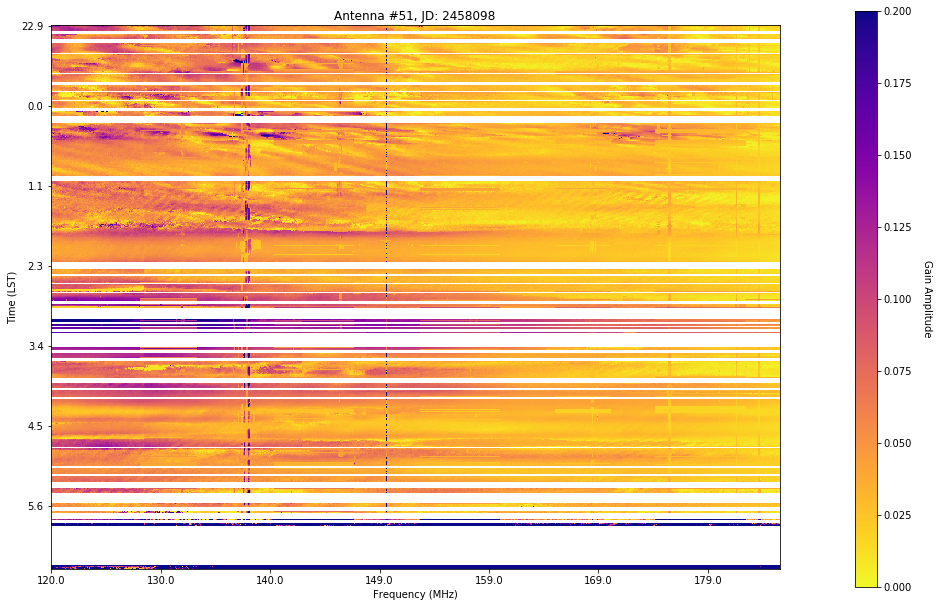

In [107]:
plotWaterfallsSingle(pyCalArray, freq_range='all', ant_nums = [51], vmax=0.2)

In [106]:
def plotWaterfallsSingle(data_array,saveFig=False,plotName='',firstFileLines=False,freq_range=[120,180],lst_range='all',days=days,vmin=0,vmax=1,ant_nums=ant_nums):
    nants = len(ant_nums)
    for k in range(len(days)):
        fig = plt.figure(figsize=(15,10))
        fig.subplots_adjust(hspace=0.5,wspace=0.5)
        fig.subplots_adjust(right=0.8)
        for j in range(nants):
            ax = fig.add_subplot(111)
            ant = ant_nums[j]
            mx = data_array[days[k]][ant]["masked_data"]
            freq_array = data_array[days[k]][ant]["freq_array"]
            if not freq_range == 'all':
                mx, freq_array = getClippedFrequency(freq_array,mx,freq_range)
            else:
                freq_range = np.around([freq_array[0],freq_array[-1]],0)
                print(freq_range)
            time_array = data_array[days[k]][ant]["lst_array"]
            zens = data_array[days[k]][ant]["zenith_RA_array"]
            if not lst_range == 'all':
                mx, time_array, idx0, idx1 = getClippedTime(time_array,mx,lst_range)
                zens = zens[idx0:idx1]
            currmap = mpl.cm.get_cmap()
            currmap.set_bad('black',1.)
            im = ax.imshow(
                mx, origin='upper', interpolation='none',
                cmap = colormap,
                aspect='auto', vmin=vmin, vmax=vmax
            )
            JD = days[k]
            ax.set_title('Antenna #' + str(ant) + ', JD: ' + str(JD))
            ax.set_xlabel('Frequency (MHz)')
            #df = (freq_range[-1] - freq_range[0])/(len(ax.get_xticks())-2)
            freq_ticks = []
            for i,ind in enumerate(ax.get_xticks()):
                if i==0 or i==len(ax.get_xticks())-1:
                    freq_ticks.append('oops')
                else:
                    freq_ticks.append(np.around(freq_array[int(ind)],0))  
            ax.set_xticklabels(freq_ticks)
            if j == 0:
                ax.set_ylabel('Time (LST)')
                idx = np.round(np.linspace(0,len(time_array)-1,10)).astype(int)
                time_ticks = np.around([time_array[i] for i in idx],1)
                ax.set_yticklabels(time_ticks)
            elif j == nants-1:
                ax.set_ylabel('RA of zenith (deg)',rotation=270,labelpad=20)
                idx = np.round(np.linspace(0,len(zens)-1,10)).astype(int)
                zen_ticks = np.around([zens[i] for i in idx],1)
                ax.set_yticklabels(zen_ticks)
                ax.yaxis.tick_right()
                ax.yaxis.set_label_position("right")
            else:
                ax.get_yaxis().set_ticklabels([])
            if firstFileLines == True:
                i = np.mod(visrange[0],12)
                while i < len(time_array):
                    ax.axhline(i,color='lightsteelblue')
                    i = i + 12
        cbar_ax = fig.add_axes([0.87,0.1,0.02,0.8])
        cbar = fig.colorbar(im, cax=cbar_ax)
        cbar.set_label('Gain Amplitude', rotation=270, labelpad=20)
        if saveFig == True:
            fig.savefig(outpath + str(days[k]) + '_waterfall_' + plotName)
            print('Saving figure to: ' + outpath + str(days[k]) + '_waterfall_' + plotName)